# Determining Max G Force during run

- filter accel data
- length of vector
- plot alongside track velocity from a50

Using Dec 30, 2023 data since only 2 runs registered (easy):

In [2]:
from load import load_2023_12_30
from sync import splitTileIntoDownhillTracks, syncTile
from signal_processing import mean, variance, std, length, lowpass
import numpy as np
import matplotlib.pyplot as plt

a50_2023_12_30, a50_all_2023_12_30, f6p_2023_12_30, tile_2023_12_30 = load_2023_12_30()

### Sync & Split Tile into runs

In [3]:
tile_2023_12_30_sync = syncTile(
    tile=tile_2023_12_30,
    truth=a50_all_2023_12_30,
    printOutput=True,
    # use_mae=False,
    time_step_s=0.5,
    max_time_search_s=30,
    alt_step=0.25,
    min_alt_start=120,
    max_alt_search=140)

Timestamp offset: 8000
Altitude offset: 131.75


In [4]:
tile_2023_12_30_runs = splitTileIntoDownhillTracks(tile_2023_12_30_sync, a50_2023_12_30)#f6p_2023_12_30, a50_all_2023_12_30, printOutput=True, start_offset=False)
print('Run count:', len(tile_2023_12_30_runs))

[[1703955989, 1703956104], [1703956733, 1703956847], [1703956907, 1703956947]]
Run count: 3


## Filtering Accelerometer

Skiing has some pretty quick motions, especially in slalom racing. However, completing fast turns down a hill is nowhere near as fast as sprinting- which is ~10Hz motion. Therfore, start with a fc of 10Hz

- fs = 100Hz
- fc = TBD


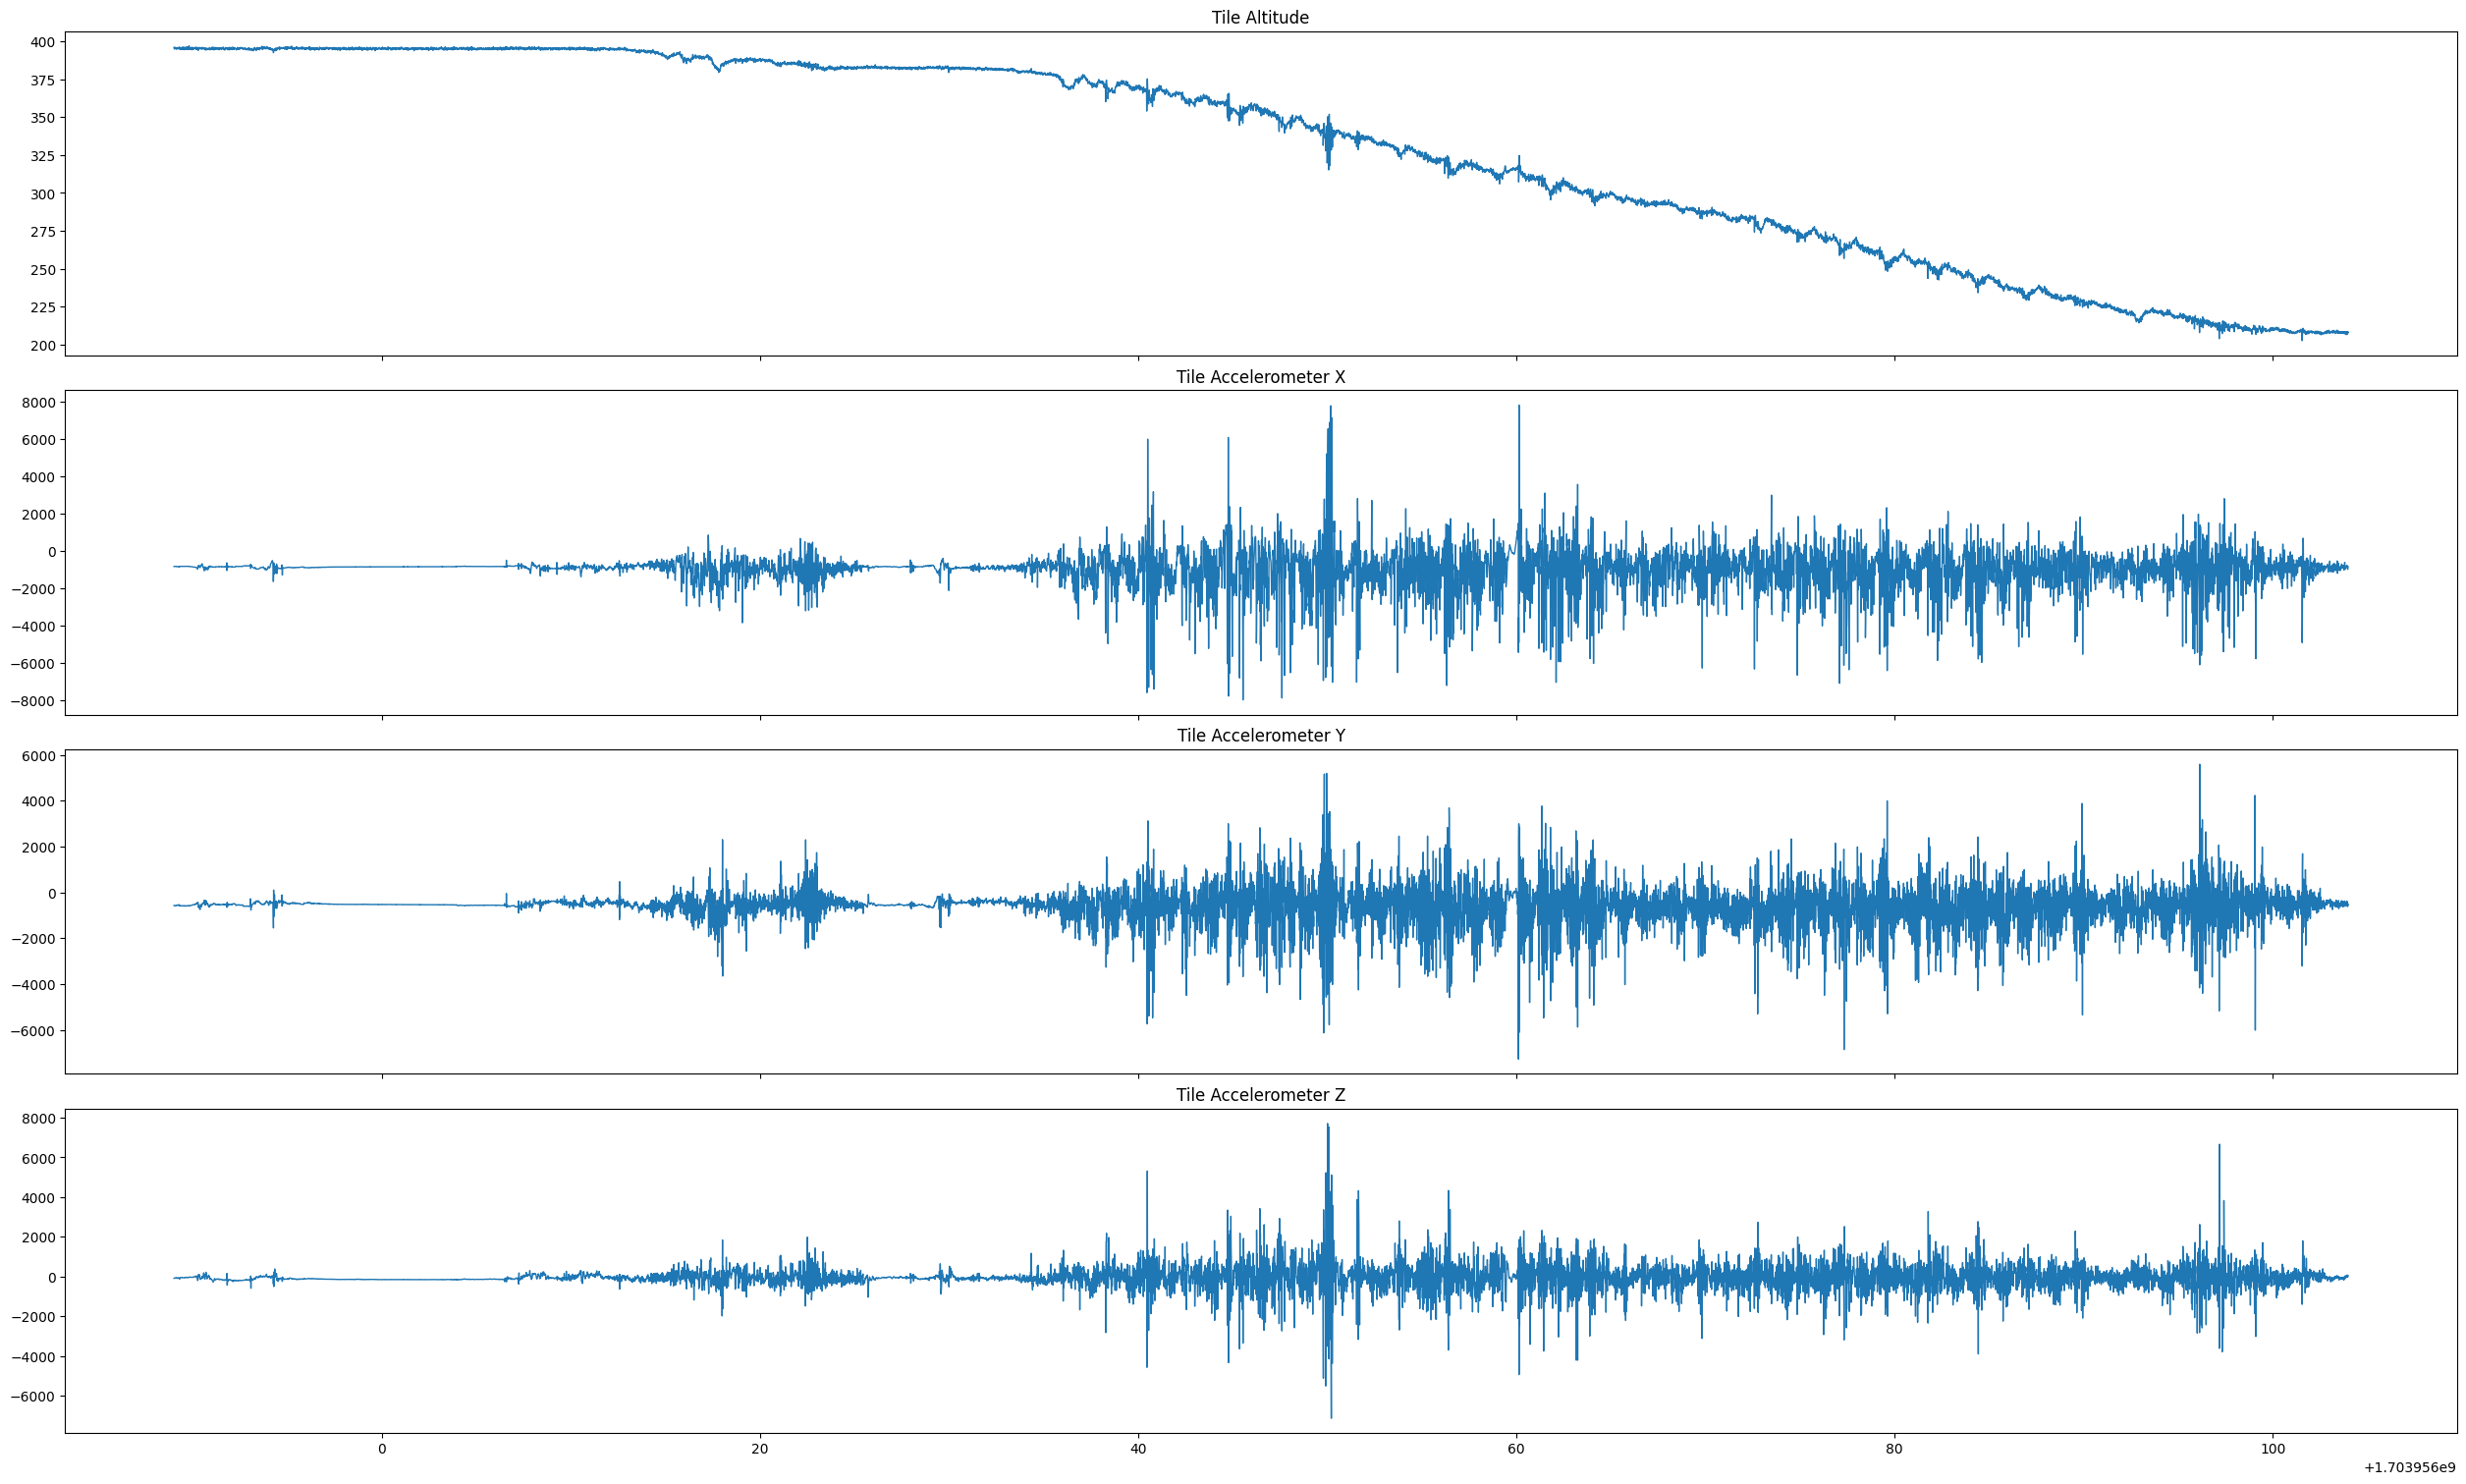

In [5]:
from plotting import plotAltAcc

run1 = tile_2023_12_30_runs[0]
run2 = tile_2023_12_30_runs[1]

plotAltAcc(run1)

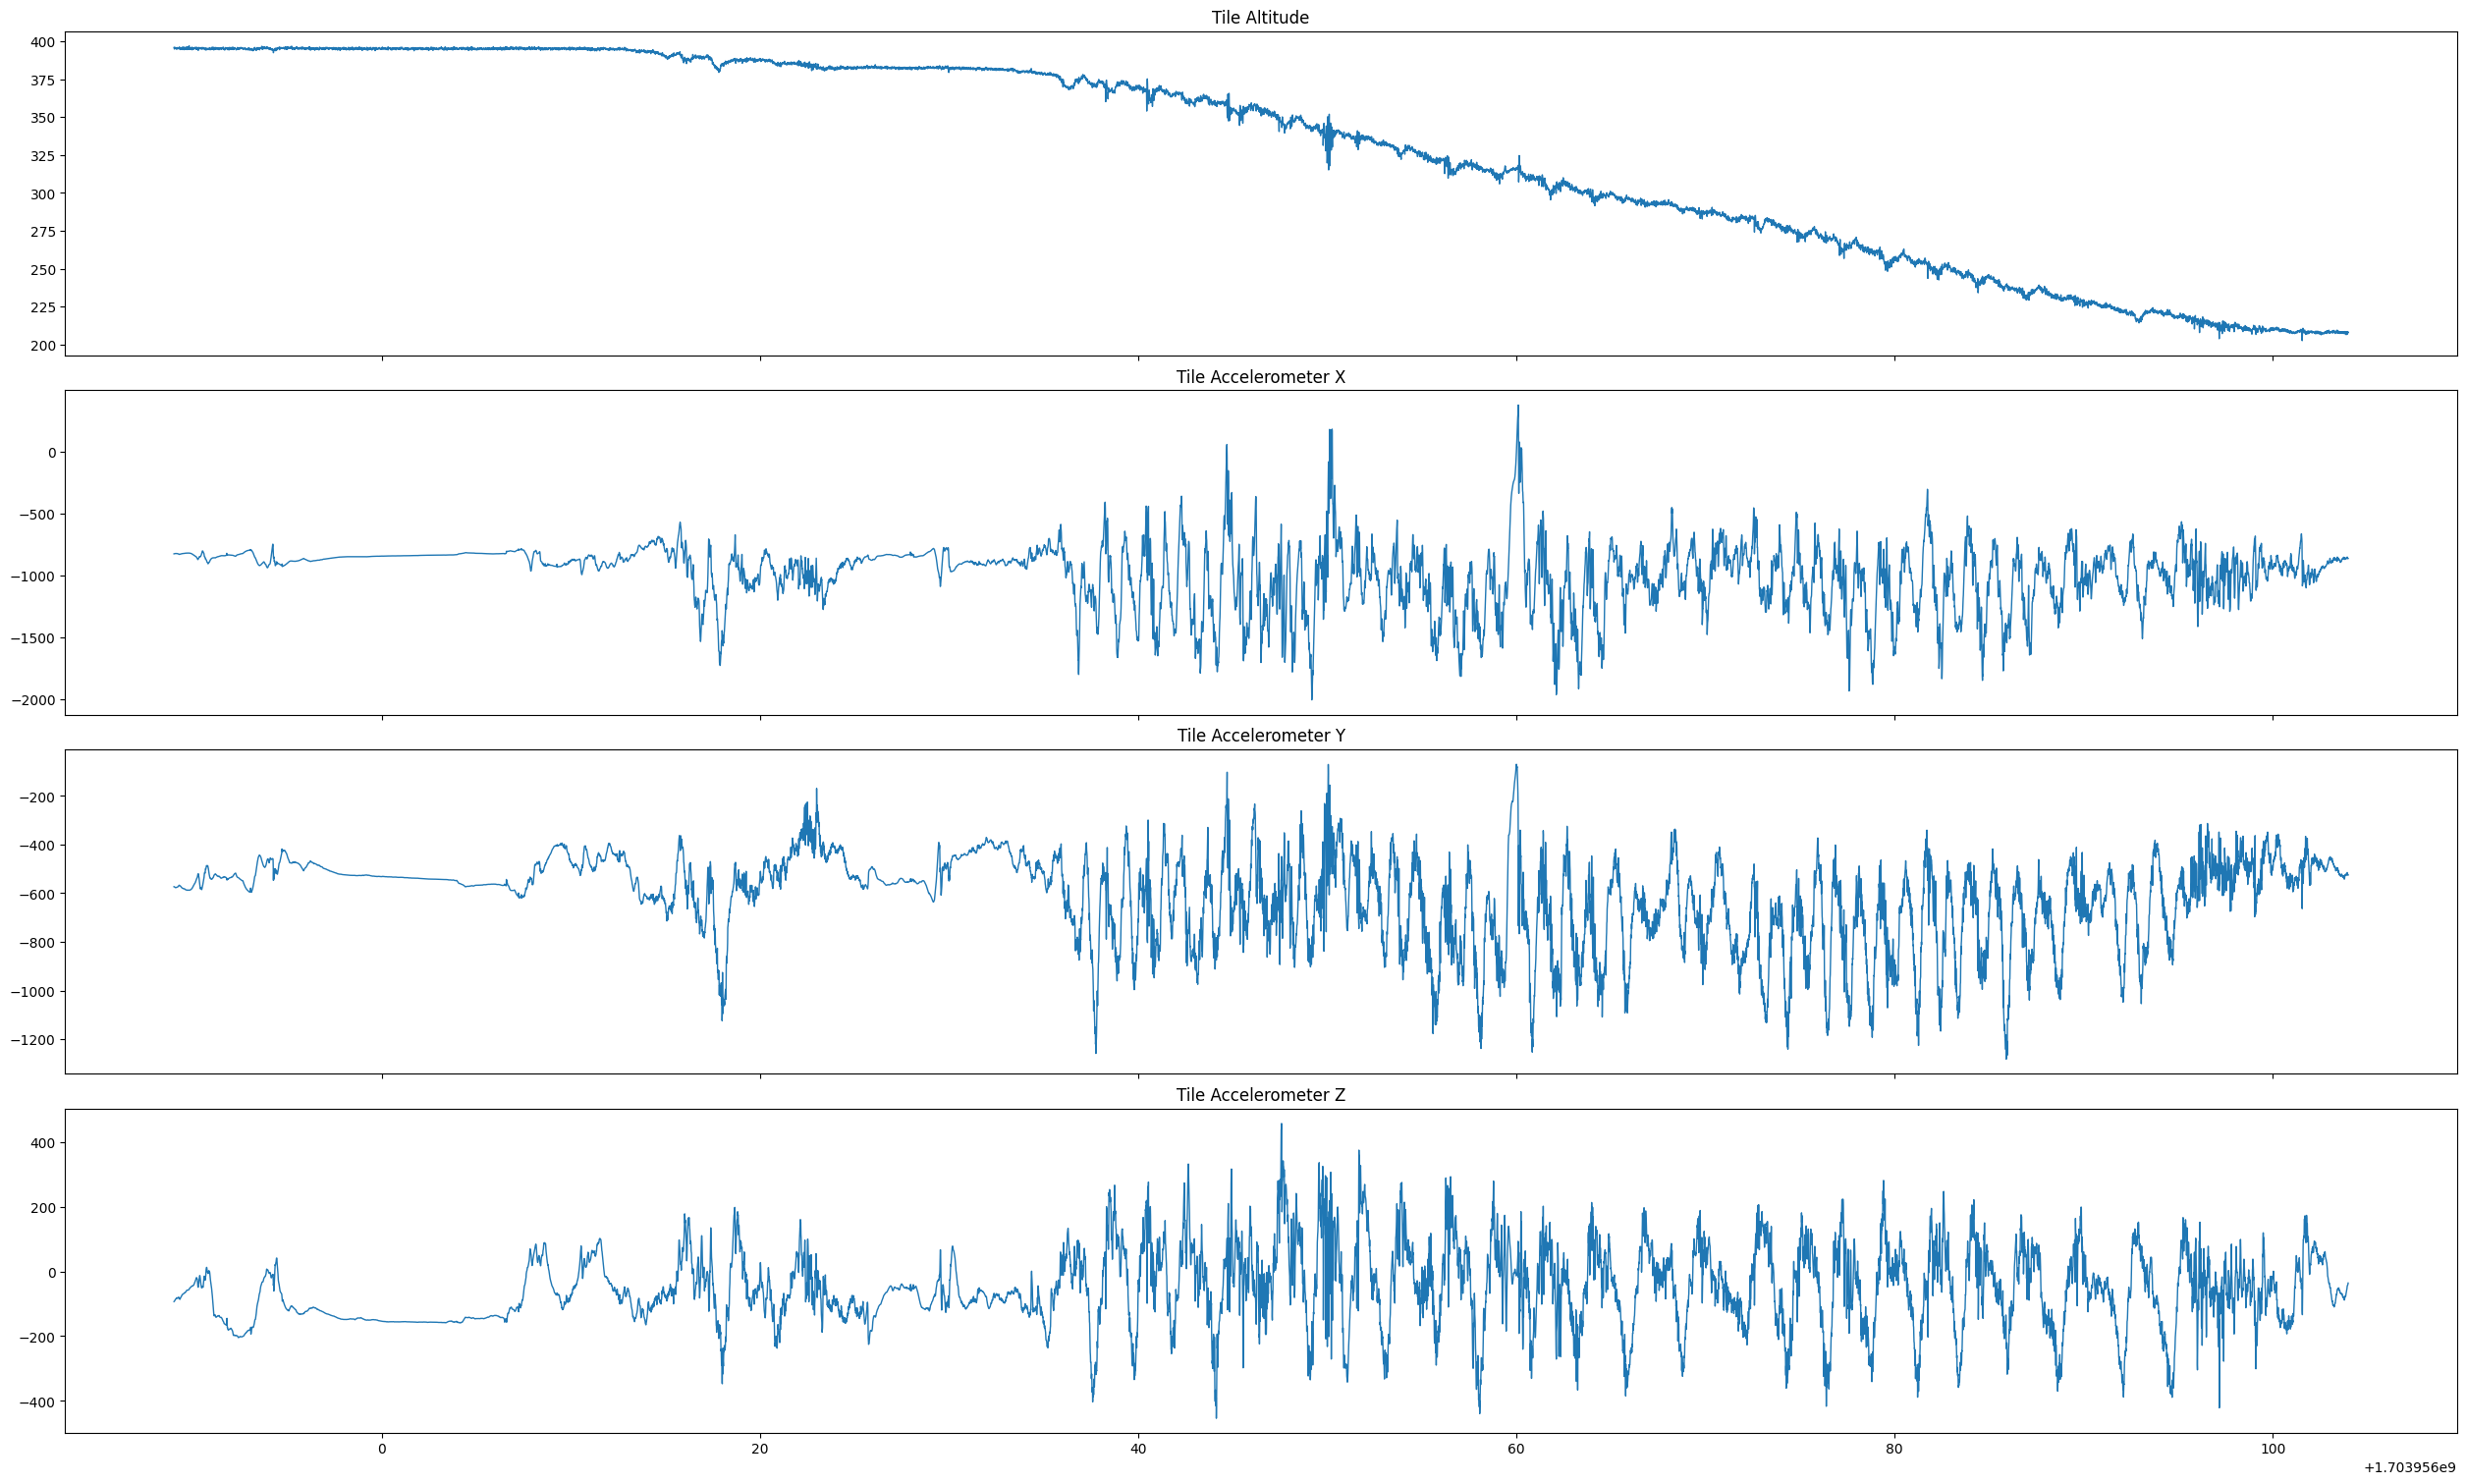

In [6]:
fc = 5
fs = 100

run1_ax_lpf = lowpass(run1.ax, fc, fs)
run1_ay_lpf = lowpass(run1.ay, fc, fs)
run1_az_lpf = lowpass(run1.az, fc, fs)

run2_ax_lpf = lowpass(run2.ax, fc, fs)
run2_ay_lpf = lowpass(run2.ay, fc, fs)
run2_az_lpf = lowpass(run2.az, fc, fs)

plotAltAcc(run1, run1_ax_lpf, run1_ay_lpf, run1_az_lpf)

## Obtaining G-Force

As the length of the vector:

In [7]:
run1_mgs = length(run1_ax_lpf, run1_ay_lpf, run1_az_lpf)
print('Run1')
print('Avg Gs:', mean(run1_mgs) / 1000)
print('Variance:', variance(run1_mgs) / 1000)
print('StdDev:', std(run1_mgs) / 1000)
print('Max Gs:', max(run1_mgs) / 1000)
print('Min Gs:', min(run1_mgs) / 1000)

print()

run2_mgs = length(run2_ax_lpf, run2_ay_lpf, run2_az_lpf)
print('Run2')
print('Avg Gs:', mean(run2_mgs) / 1000)
print('Variance:', variance(run2_mgs) / 1000)
print('StdDev:', std(run2_mgs) / 1000)
print('Max Gs:', max(run2_mgs) / 1000)
print('Min Gs:', min(run2_mgs) / 1000)


Run1
Avg Gs: 1.1706696331314053
Variance: 79.99586371519096
StdDev: 0.28283540039250915
Max Gs: 2.2394828447150155
Min Gs: 0.0709399736148201

Run2
Avg Gs: 1.1357821698476294
Variance: 58.70567102767894
StdDev: 0.2422925319271705
Max Gs: 2.276318794993731
Min Gs: 0.4087426508440367


Comparing to the unfiltered signal, the noise is wild. The filtered signal will be good for identifying turns and moments of lower freq, but the unfiltered g-force should be used to identify impulses- which are still important.

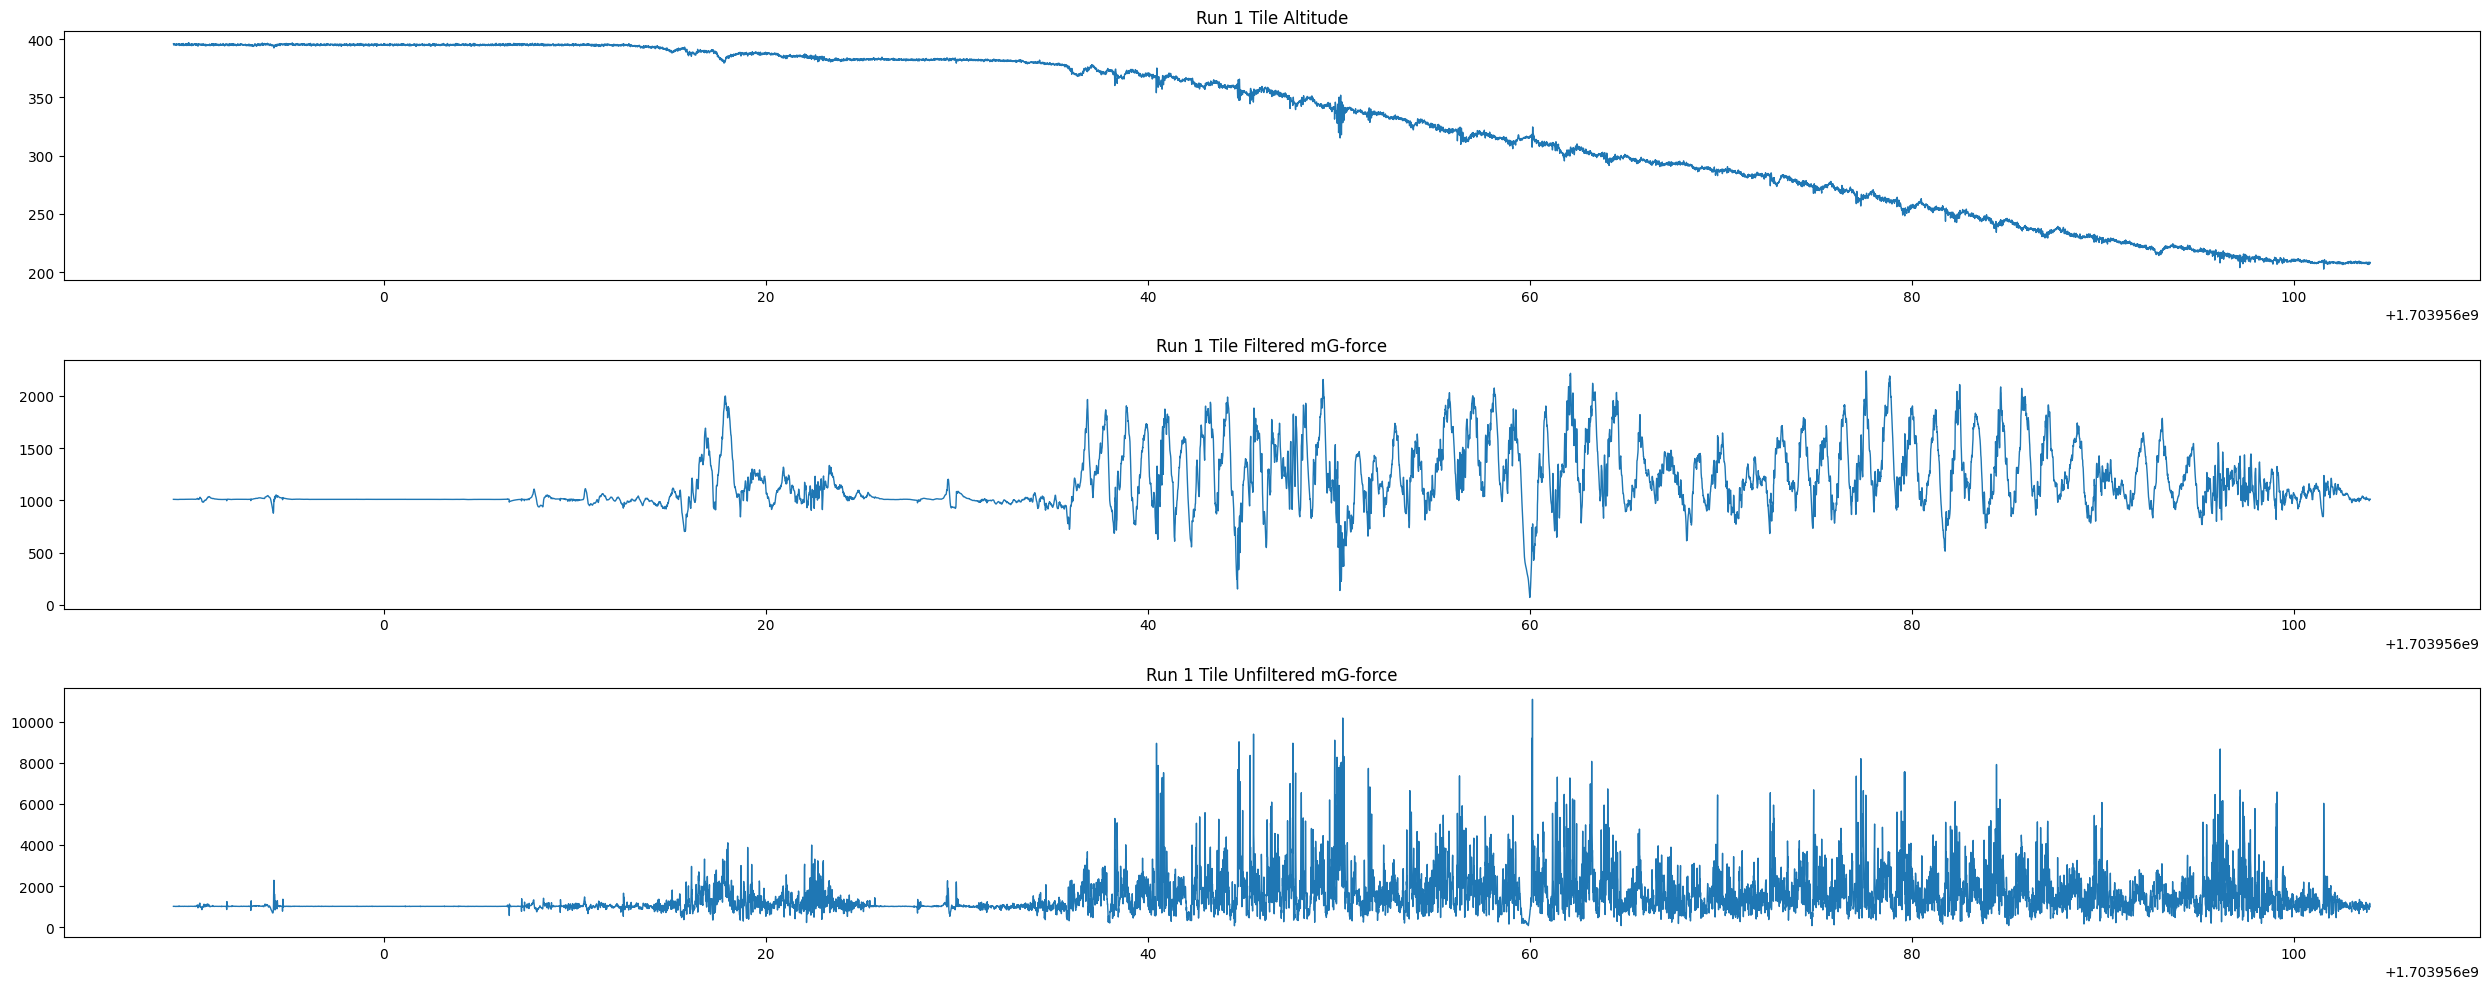

In [9]:
plt.rc('lines', linewidth=1)
_, ax = plt.subplots(3, figsize=(25, 10))
ax[0].plot(run1.time, run1.alt)
ax[0].set_title('Run 1 Tile Altitude', wrap=True)

ax[1].plot(run1.time, run1_mgs)
ax[1].set_title('Run 1 Tile Filtered mG-force', wrap=True)

ax[2].plot(run1.time, length(run1.ax, run1.ay, run1.az))
ax[2].set_title('Run 1 Tile Unfiltered mG-force', wrap=True)

plt.tight_layout()
plt.show()